In [1]:
import sys, os
import source.map
import source.measurement
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [6]:
species = [(0.06, 130, 0, {2}, (0, 0, 1, 1), 200, 101, 100, 0.01, 0.15, 0, 0.03, 0.05, 0.05, 1200),
           (0.14, 130, 1, {0}, (1, 0, 0, 1), 400, 151, 150, 0.01, 0.15, 5, 0.011, 0.1, 0.05, 700),
           (0, 10, 2, set(), (0, 0.8, 0.2, 1), 50, 40, 1000, 0.01, 0.15, 0, 0, 0, 0, 3000),
          ]

the_map = source.map.Map([200, 10, 6500], 60, 60, species, decease_spread_range=2)

Schéma animé de monde:

In [22]:
for i in range(1000):
    the_map.iteration()

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


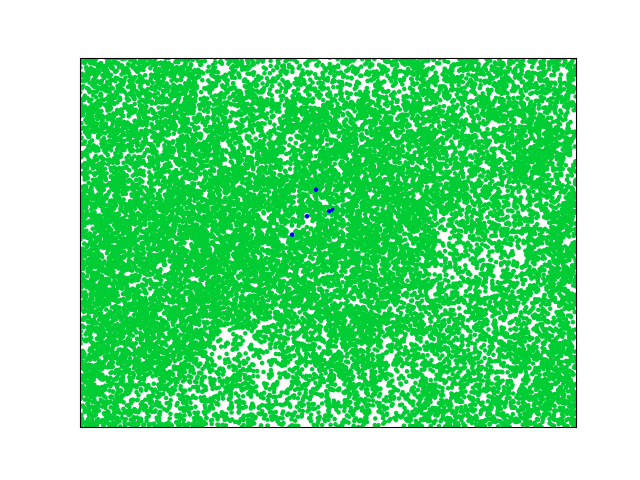

In [23]:
%matplotlib notebook

import numpy as np
import matplotlib.animation as animation

plt.close('all')


fig = plt.figure(5)
ax = plt.axes(xlim=(0, the_map.beings_map.shape[0]), ylim=(0, the_map.beings_map.shape[1]))
scat = ax.scatter([], [], s=60)
plt.xticks([]), plt.yticks([])


def init():
    scat.set_offsets([])

def update(*args):
    positions = []
    colors = []
    for i in range(len(the_map.beings_list)):
        if not the_map.beings_list[i].is_dead:
            positions.append(the_map.beings_list[i].get_position())
            colors.append(the_map.beings_list[i].color)
    scat.set_offsets(positions)
    scat.set_color(colors)
    scat.set_sizes(5 * np.ones(len(the_map.beings_list)))
    the_map.iteration()
    return scat,

anim = animation.FuncAnimation(fig, update, init_func=init, frames=range(100),
                               interval=50)
plt.show()

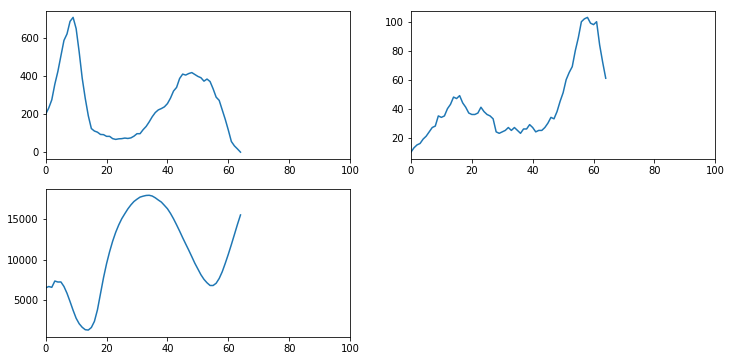

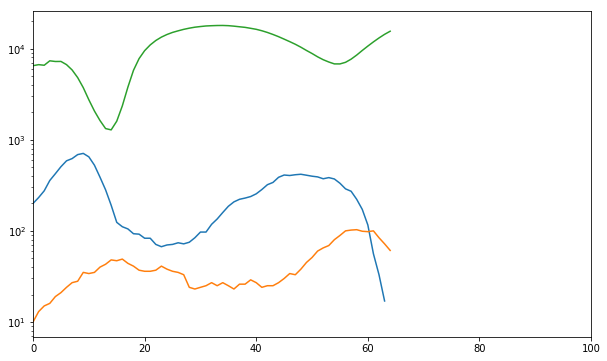

In [7]:
source.measurement.draw_population(the_map,
                                   100,
                                   60,
                                   species_to_draw={0, 1, 2},
                                   stop_on_extinction=True)

In [5]:
the_map.stats

{'born': array([ 0.,  0.,  0.]),
 'died_of_hunger': array([ 0.,  0.,  0.]),
 'died_of_illness': array([ 0.,  0.,  0.]),
 'died_of_old_age': array([ 0.,  0.,  0.]),
 'eaten': array([ 0.,  0.,  0.])}